In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
# import seaborn as sns
import re
import nltk
from sklearn import ensemble
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import gutenberg, stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
lmtzr= WordNetLemmatizer()
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
%matplotlib inline

## The CORPSE (corpus*)

For this capstone I am going to use the gutenberg corpus, as I know it has enough entries and authors to work with. I am choosing 10 texts from the corpus.
Also, I am familiar with it from the lessons, which lends itself to additional exploratory work and feature generation. 


In [2]:
my_stopwords = stopwords.words('english')

In [4]:
for fileid in gutenberg.fileids():
    num_chars = len(gutenberg.raw(fileid))
    num_words = len(gutenberg.words(fileid))
    num_sents = len(gutenberg.sents(fileid))
    num_vocab = len(set(w.lower() for w in gutenberg.words(fileid)))
    print(num_chars,num_words,num_sents,num_vocab, fileid)

887071 192427 7752 7344 austen-emma.txt
466292 98171 3747 5835 austen-persuasion.txt
673022 141576 4999 6403 austen-sense.txt
4332554 1010654 30103 12767 bible-kjv.txt
38153 8354 438 1535 blake-poems.txt
249439 55563 2863 3940 bryant-stories.txt
84663 18963 1054 1559 burgess-busterbrown.txt
144395 34110 1703 2636 carroll-alice.txt
457450 96996 4779 8335 chesterton-ball.txt
406629 86063 3806 7794 chesterton-brown.txt
320525 69213 3742 6349 chesterton-thursday.txt
935158 210663 10230 8447 edgeworth-parents.txt
1242990 260819 10059 17231 melville-moby_dick.txt
468220 96825 1851 9021 milton-paradise.txt
112310 25833 2163 3032 shakespeare-caesar.txt
162881 37360 3106 4716 shakespeare-hamlet.txt
100351 23140 1907 3464 shakespeare-macbeth.txt
711215 154883 4250 12452 whitman-leaves.txt


OK, I only am going to use 10 pieces of text (by ten authors). I am going to leave out melville and the bible as these are much longer texts. For the authors with multiple texts, I will choose one. Per the unsupervised lession I am going to load the texts in by paragraphs. I also am going to go ahead and apply the text cleaner when i store the texts into their designated variables

## Cleaning and parsing

In [78]:
import string
my_stopwords = stopwords.words('english')

In [79]:
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    text = re.sub(r"'",' ',text)
    text = re.sub(r'"',' ',text)
    text = re.sub("[\[].*?[\]]", ' ', text)
    text = ' '.join(text.split()).lower()
    
    return text

In [80]:
text_list =['austen-persuasion.txt','blake-poems.txt','bryant-stories.txt','burgess-busterbrown.txt',\
            'carroll-alice.txt','chesterton-thursday.txt','edgeworth-parents.txt','shakespeare-caesar.txt',\
            'milton-paradise.txt','whitman-leaves.txt']

In [81]:
author_list=[]
for text in text_list: 
    author = text.split('-')[0]
    author_list.append(author)

In [82]:
author_list

['austen',
 'blake',
 'bryant',
 'burgess',
 'carroll',
 'chesterton',
 'edgeworth',
 'shakespeare',
 'milton',
 'whitman']

In [83]:
books = []
for i in range(len(text_list)):
    file_name = text_list[i]
    books_of_paragraphs = gutenberg.paras(file_name)
    clean_paragraph = []
    for paragraph in books_of_paragraphs:
        
        para = paragraph[0]
        sentence_as_string = ' '.join(para)
        sentence_as_string = text_cleaner(sentence_as_string).lower()

        clean_paragraph.append(sentence_as_string)
    books.append(clean_paragraph)


In [12]:
def all_the_good_stuff(tokenized_texts, include_stop=False):
    new_txt=[]
    for paragraph in tokenized_texts: 
        list_of_tokens = word_tokenize(paragraph)
        processed_texts = []
        for token in list_of_tokens: 
            if (token not in my_stopwords or include_stop) and (token not in string.punctuation): 
                processed_texts.append(token)
               
        if len(processed_texts) > 3:
            new_txt.append(" ".join(processed_texts))
    return new_txt

In [13]:
df = pd.DataFrame()
for book, author in zip(books, author_list):

    book = all_the_good_stuff(book, include_stop = False)
    book = [[paragraph, author] for paragraph in book]
    book = pd.DataFrame(book, columns = ['text','author'])
    df = df.append(book, ignore_index = True)

In [84]:
df.head()

,text,author
0,sir walter elliot kellynch hall somersetshire ...,austen
1,walter elliot born march 1 1760 married july 1...,austen
2,precisely paragraph originally stood printer h...,austen
3,followed history rise ancient respectable fami...,austen
4,heir presumptive william walter elliot esq gre...,austen


In [16]:
df.shape

(7839, 2)

In [17]:
df.author.value_counts()

edgeworth      2347
whitman        1856
chesterton      942
bryant          897
austen          757
carroll         557
blake           206
burgess         189
shakespeare      73
milton           15
Name: author, dtype: int64

edgeworth text comprises about 28% of all sentences in my data frame. I need to keep this in mind, as ideally I would want to have a similar number of paragraphs for each author.

# Cluster time!


## Let's start by vectorizing

In [165]:
X = df['text']
Y = df['author']

X_train, X_test = train_test_split(X, test_size=0.25, random_state=12)

vectorizer = TfidfVectorizer(max_df=0.6, # drop words that occur in more than 60% of paragraphs
                             min_df=6, # only use words that appear at lea|st 3x
                             stop_words='english', # mostly redundant, but it's ok 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we d||efinitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Starting with L2 regularization
                             smooth_idf=True #Prevents divide-by-zero errors
                            )

#Applying the vectorizer
para_tfidf = vectorizer.fit_transform(X)
print("Number of features: %d" % para_tfidf.get_shape()[1])

#splitting into training and test sets. Reserving 25% of my corpus as a test set.
X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(para_tfidf, 
                                                                Y,
                                                                test_size=0.25,
                                                                random_state=12)

Number of features: 3130


let's reduce the number of features to the most valuable components.I will try to find the best number of compoentns for SVD using a for loop

In [146]:
# for i in range(200, 3000, 200):
#     svd= TruncatedSVD(i)
#     lsa = make_pipeline(svd, Normalizer(copy=False))
#     # Run SVD on the training data, then project the training data.
#     X_train_lsa = lsa.fit_transform(X_train_tfidf)

#     variance_explained=svd.explained_variance_ratio_
#     total_variance = variance_explained.sum()
#     print(i)
#     print("Percent variance captured by all components:",total_variance*100)

I have a feeling that using more componentws will slow down the runining time, so I am going to choose less components than ideal, with the understanding that i will be forgoing variance expained for limiting them. 

In [166]:
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
#creating test lsa group for later
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 21.8828553433


## Now lets cluster

The good news here is that we do have a ground truth (who the authors of each paragraph are), so there are a few evalaution techniques that we can employ.

### K-means
going to start with using 10 clusters, as I have 10 authors in the corpus.

In [108]:
k_mean = KMeans(n_clusters=10, random_state=12)
k_mean.fit(X_train_lsa)
Y_pred = k_mean.predict(X_train_lsa)

In [109]:
#cross tab!!! to see how we are doing
print(pd.crosstab(Y_train.values, Y_pred))

col_0          0    1    2    3    4   5   6    7    8    9
row_0                                                      
austen        40  385    7    7   16  24  24   52    0   20
blake          4   58   21   60    5   3   1    0    0   14
bryant       100  281   14   40   33  31  23    0    0  171
burgess        8   79    0    0    7   5   3    3    0   43
carroll      140  148    4    8   33  26   7    0    0   35
chesterton   147  254    6   36   23  13  12    4  194   17
edgeworth    327  851   31   40  119  61  91  123    0   87
milton         0    4    2    5    0   0   0    0    0    0
shakespeare    0   23   19    6    3   0   0    0    0    0
whitman        3  323  152  705   98  59  38    0    0   20


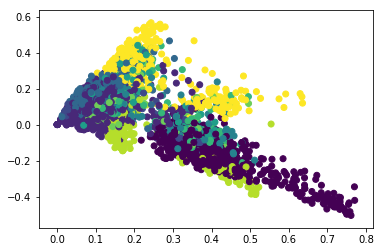

In [99]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=Y_pred)
plt.show()


In [100]:
#now since we have a ground truth we can calucalte the ARI score to understand the randomness in the assignment of clusters. 
metrics.adjusted_rand_score(Y_train.values, Y_pred)

0.095765048266564637

OK, this the ARI score indicates that our clustering solution is more random than ideal, but there does appear to be some semblance of correct prediction.

In [152]:
X_train_tfidf = vectorizer.transform(X_train)
X_train_lsa = lsa.fit_transform(X_train_tfidf)


In [137]:
#Looking at what sorts of paragraphs our solution considers similar, for the first 10 components
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(11):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
text
said ill gotten wealth quickly spent proved instance                                                                           0.774956
something said wanted much last winter ill rheumatism something said yesterday making bed wished might able buy next winter    0.767898
would disgrace said one subjects dared disobey                                                                                 0.763787
done us said brief military irony                                                                                              0.762059
go said edmund sturdily                                                                                                        0.756175
said nothing said marquis except something band                                                                                0.753992
jolly get pals said                                                                                                            0.752378
expect indeed said betty comfo

In [138]:
cluster_df = pd.DataFrame({'para':X_train, 'cluster':Y_pred})
for clust in np.arange(0,11,1):
    print(cluster_df[cluster_df['cluster'] == clust].head(10))

      cluster                                               para
5770        0  sir said hardy firm respectful voice pardon as...
4187        0               yes said philip forget may day hurry
642         0  smallest intention asking said elizabeth affec...
5469        0                  make shillings day slow work said
2584        0  begin beginning king said gravely go till come...
2496        0     yes think better leave said gryphon alice glad
2913        0            said president nodding great many times
3413        0                 dogs barking course said secretary
1677        0  going dublin said tailor build court king get ...
2366        0        fetch executioner said king eagerly hurried
      cluster                                               para
2411        1  walked together alice heard king say low voice...
3278        1  spoke swept round corner man rigid rushing hor...
5071        1  scarcely assembly adjourned ball alley fisher ...
7083        1  say linger

OK, so looking at the components, it appears that the clustering solution is basing the solution based in more topical themes or even common words. Component 1 relatd to something being said, comp 1 relates to being little, as does comp 2. Others include paragrpahs relating to proper names, or relating to numeric numbers. However, it does appear that the components consist of paragraphs from (mostly) the same author. Ideally I might want to deal with the common words and numeric types, but let's conitnue on for the purposes of the capstone. Looking at the actual clusters reveals what I saw in the comps. However, there are some clusters that seem to perfectly preduct the author (cluster 8), while others are very close (cluster 7).  Let's try a couple more types of clusters.


### Mean Shift

In [141]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.4, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

print('\nComparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train.values, labels))



Number of estimated clusters: 1

Comparing the assigned categories to the ones in the data:
col_0           0
row_0            
austen        575
blake         166
bryant        693
burgess       148
carroll       401
chesterton    706
edgeworth    1730
milton         11
shakespeare    51
whitman      1398


using the bandwidth we calculated (and after adjusting the parameters), its is clear that mean shift does work for our purposes as it only is creating 1 cluster. Manually adjusting the bandwith does increase the number of clusters, but it still does not appear to be assinged by author. Let's go back to k-means quickly to run minibatch

In [148]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=200)
minibatchkmeans.fit(X_train_lsa)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_train_lsa)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(Y_train.values, predict_mini))

Comparing k-means and mini batch k-means solutions:
col_0         0    1    2    3   4   5    6    7    8    9
row_0                                                     
austen       17   15  198   33  23  11    6   10  244   18
blake        15   39   28    3   1  10   32   22    5   11
bryant       23   54  221  107  11  31   30   28   11  177
burgess       6    5   69    9   2   6    3    3    0   45
carroll      10   11  138  153   2  23   19    2    6   37
chesterton   16   43  283  218   6  22   43   19   34   22
edgeworth    46   63  826  413  30  98   36   54   64  100
milton        0    5    2    0   1   1    1    1    0    0
shakespeare   1    5   25    0   1   0   10    1    8    0
whitman      68  695  228    3  14  15  130  105  117   23


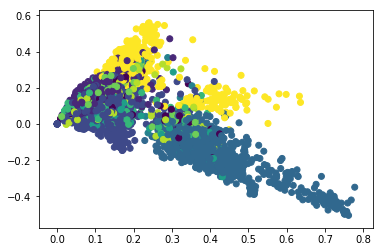

In [150]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict_mini)
plt.show()

In [151]:
metrics.adjusted_rand_score(Y_train.values, predict_mini)

0.12126223566183919

This is a little better. Let's look at the componenets

In [153]:
#Looking at what sorts of paragraphs our solution considers similar, for the first 10 components
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(11):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
text
something said wanted much last winter ill rheumatism something said yesterday making bed wished might able buy next winter    0.762701
said ill gotten wealth quickly spent proved instance                                                                           0.761764
done us said brief military irony                                                                                              0.761309
would disgrace said one subjects dared disobey                                                                                 0.760542
go said edmund sturdily                                                                                                        0.757126
expect indeed said betty comforter                                                                                             0.754545
said nothing said marquis except something band                                                                                0.753708
pepper mostly said cook       

In [155]:
cluster_df = pd.DataFrame({'para':X_train, 'cluster':predict_mini})
for clust in np.arange(0,11,1):
    print(cluster_df[cluster_df['cluster'] == clust].head(10))

      cluster                                               para
5518        0  left minutes brother could think anybody would...
843         0  southern clime summer prime never fades away l...
1608        0        king sad hear rejoiced friendship fairy son
7079        0  wife side lies slumbering wars long head pillo...
4920        0                 bell rang answered squeaking voice
2226        0  duchess sang second verse song kept tossing ba...
1237        0  old alligator hidden away beneath mud bulrush ...
1084        0                 suppose yet unless somebody picked
6294        0      one pumps shot away generally thought sinking
1230        0                     much jove angry stupidity last
      cluster                                               para
6679        1  around palace loftier fairer ampler yet earth ...
6114        1  guess must flag disposition hopeful green stuf...
7682        1  sing last equalities modern old sing endless f...
6967        1  paumanok s

About the same as before

### Spectral


In [156]:

n_clusters=10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters, random_state = 12)
Y_pred_sc = sc.fit_predict(X_train_lsa)


print('Comparing the clisters against the aithors:')
print(pd.crosstab(Y_train.values,Y_pred_sc))

Comparing the clisters against the aithors:
col_0          0    1    2    3   4    5    6    7     8   9
row_0                                                       
austen       220   13    4   13  13   59   12    0   236   5
blake          0   12   45    4   3    0    9    0    88   5
bryant         0  164   29   87  15    0   53    0   336   9
burgess        0   43    0    8   6    0    4    0    87   0
carroll        0   30    5  129  30    1    6    0   197   3
chesterton     0   17   20  120  11   11   59  173   286   9
edgeworth     12   81   28  248  71  176   77    0  1008  29
milton         0    0    5    0   0    0    1    0     5   0
shakespeare    0    0   10    0   2    0    0    0    31   8
whitman        1   18  685    1  52    0  115    0   469  57


In [157]:
metrics.adjusted_rand_score(Y_train.values, Y_pred_sc)

0.10036837130122282

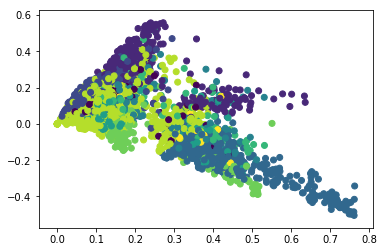

In [158]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=Y_pred_sc)
plt.show()

This might actually be a litl better than k means. There definitely appears to be a reasonably accurate prediction of author, alothout it not perfect. The issues are likely due to the large size of the edeworth text.


In [159]:
cluster_df = pd.DataFrame({'para':X_train, 'cluster':Y_pred_sc})
for clust in np.arange(0,11,1):
    print(cluster_df[cluster_df['cluster'] == clust].head(10))

      cluster                                               para
642         0  smallest intention asking said elizabeth affec...
362         0  anne never entered kellynch since quitting lad...
645         0  anne distressing see mr elliot enter room quit...
185         0  actually sofa mrs musgrove readily made room d...
3874        0  surprised though continued mrs pomfret proceed...
508         0  admiral croft taking walk anne expressing wish...
487         0  sir walter elizabeth share interest letter mrs...
5833        0                   could give grandmother said anne
176         0  felt luck admiral assure replied captain wentw...
330         0  anne attending strength zeal thought instinct ...
      cluster                                               para
1871        1                     little joe otter terrible rage
2123        1  luckily alice little magic bottle full effect ...
2062        1  indeed ten inches high face brightened thought...
3459        1            

While there is still al ot of overlap, the clustering does fairly well. It is very topical and picks up common words themes, but once again its not perfect. How does it work on the test set? 

In [160]:
X_test_tfidf = vectorizer.transform(X_test)
X_test_lsa = lsa.fit_transform(X_test_tfidf)
Y_pred_test  = sc.fit_predict(X_test_lsa)

In [161]:
print('Comparing the clisters against the aithors:')
print(pd.crosstab(Y_test.values,Y_pred_test))

Comparing the clisters against the aithors:
col_0          0    1   2   3   4    5   6   7   8   9
row_0                                                 
austen         3  139   0   6   3    7   6   7   4   7
blake         26    7   0   1   0    0   4   0   2   0
bryant        16   85   0   2   7   27  48   7   4   8
burgess        1   30   0   2   1    0   6   0   0   1
carroll        4   45   0   5   5   32   7   7  51   0
chesterton    22   68  65   3   0   52   4   5  11   6
edgeworth     38  335   0  30  23  106  22   9  18  36
milton         3    1   0   0   0    0   0   0   0   0
shakespeare    5   15   0   0   0    0   0   0   0   2
whitman      283   65   0  15  24    4   8  36   9  14


In [162]:
cluster_df = pd.DataFrame({'para':X_test, 'cluster':Y_pred_test})
for clust in np.arange(0,11,1):
    print(cluster_df[cluster_df['cluster'] == clust].head(10))

      cluster                                               para
6120        0  grass dark white heads old mothers darker colo...
3298        0       cut short bang blaze light seemed close eyes
4580        0  father said arthur trying stop sobbing thing s...
3154        0  felt strange vivid value earth around grass fe...
7827        0                      commonplace sing cheap health
4830        0                       old worship would give leave
991         0  said words wonderful light glowed heart sound ...
7719        0  carol closing sixty nine resume repetition lin...
7301        0  shows laboring life city country women men chi...
869         0  happy dance sing think done injury gone praise...
      cluster                                               para
1731        1  crash din came voices giant maidens loudly cha...
4025        1  interval bab employed much satisfaction cross ...
619         1  letter could read without putting anne glow mr...
61          1  sir walter

In [163]:
metrics.adjusted_rand_score(Y_test.values, Y_pred_test)

0.14438233026647196

Not bad, definitely some overlapping clusters, but they do still to cluster based on common words/themese.
Also, like the train group, the test group is better at clustering certain authors (whitman and chesteron) than others. 
Maybe in the future, I would want to remove edgeworth, or only take a sample of his text.

## Supervisedddd!

Going to use the tfidf first, as well as the lsa of tfidf. Then going to try BOW

### rfc

In [167]:
from sklearn.model_selection import cross_val_score


rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X_train_lsa,Y_train)

print('Training set score:', rfc.score(X_train_lsa,Y_train))
print('\nTest set score:', rfc.score(X_test_lsa, Y_test))


Training set score: 0.992515733968

Test set score: 0.629591836735


In [168]:
#try tdidf and not lsa
rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X_train_tfidf,Y_train)

print('Training set score:', rfc.score(X_train_tfidf,Y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, Y_test))

Training set score: 0.990984861371

Test set score: 0.735714285714


better!!! LETS TRY BOW

In [182]:
X = df['text']
Y = df['author']

vectorizer = TfidfVectorizer(max_df=0.6, # drop words that occur in more than 60% of paragraphs
                             min_df=6, # only use words that appear at least 3x
                             stop_words='english', # mostly redundant, but it's ok 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=False,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Starting with L2 regularization
                             smooth_idf=True #Prevents divide-by-zero errors
                            )

#Applying the vectorizer
sentence_bow= vectorizer.fit_transform(X)


#splitting into training and test sets. Reserving 25% of my corpus as a test set.
X_train_bow, X_test_bow, Y_train, Y_test = train_test_split(sentence_bow, 
                                                                Y,
                                                                test_size=0.25,
                                                                random_state=12)



In [183]:
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa_bow = lsa.fit_transform(X_train_bow)
#creating test lsa group for later
X_test_lsa_bow = lsa.transform(X_test_bow)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 32.5625447813


In [171]:

rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X_train_bow,Y_train)

print('Training set score:', rfc.score(X_train_bow,Y_train))
print('\nTest set score:', rfc.score(X_test_bow, Y_test))

Training set score: 0.988603503997

Test set score: 0.73112244898


Slight improvment. I can try tweaking the params of rfc, lets try that before moving on to other models. 
GRID SEARCH!

In [78]:
from sklearn.model_selection import GridSearchCV
param_search = [{'n_estimators': [2,5,10,20,100],
          'max_depth': [3,6,15,20],
          'min_samples_split':[2,6,10,15,20]}]


# Initialize and fit the model.
rfc_grid = GridSearchCV(ensemble.RandomForestClassifier(), param_grid=param_search,cv=5)

rfc_grid.fit(X_train_bow,Y_train)

print('Best Score: ', rfc_grid.best_score_)
print('Best Parameters: ', rfc_grid.best_params_)

Best Score:  0.605375063786
Best Parameters:  {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [174]:

rfc = ensemble.RandomForestClassifier(n_estimators= 100, max_depth = 20, min_samples_split = 10)
rfc.fit(X_train_bow,Y_train)

print('Training set score:', rfc.score(X_train_bow,Y_train))
print('\nTest set score:', rfc.score(X_test_bow, Y_test))



Training set score: 0.640925327437

Test set score: 0.623469387755


Correcting the overfitting but at the sake of some accuracy. Lets try log

### logisticccc

In [175]:
#logistic
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression()
lr.fit(X_train_lsa, Y_train)

print('Training set score:', lr.score(X_train_lsa,Y_train))
print('\nTest set score:', lr.score(X_test_lsa, Y_test))



Training set score: 0.740091852356

Test set score: 0.723469387755


In [176]:
#logistic with tdidf
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression()
lr.fit(X_train_tfidf, Y_train)

print('Training set score:', lr.score(X_train_tfidf,Y_train))
print('\nTest set score:', lr.score(X_test_tfidf, Y_test))



Training set score: 0.860350399728

Test set score: 0.783673469388


In [177]:
#logistic with bow
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression()
lr.fit(X_train_bow, Y_train)

print('Training set score:', lr.score(X_train_bow,Y_train))
print('\nTest set score:', lr.score(X_test_bow, Y_test))


Training set score: 0.836877019901

Test set score: 0.76887755102


tfidf and bow are pretty similar. A little overfitting, but let's try tweaking bow with grid search. 

In [106]:
param_search = [{'penalty':('l1', 'l2'),
                 'C':(.001, .01, .1, 1, 100)}]


# Initialize and fit the model.
lr_grid = GridSearchCV(LogisticRegression(), param_grid=param_search,cv=5)

lr_grid.fit(X_train_bow,Y_train)

print('Best Score: ', lr_grid.best_score_)
print('Best Parameters: ', lr_grid.best_params_)

Best Score:  0.801156659296
Best Parameters:  {'C': 100, 'penalty': 'l2'}


In [178]:
lr =  LogisticRegression(C=100, penalty='l2')
lr.fit(X_train_bow, Y_train)

print('Training set score:', lr.score(X_train_bow,Y_train))
print('\nTest set score:', lr.score(X_test_bow, Y_test))


Training set score: 0.996938254805

Test set score: 0.81887755102


In [110]:
#Going to try tuning with lsa of tfidf

param_search = [{'penalty':('l1', 'l2'),
                 'C':(.001, .01, .1, 1, 100)}]



# Initialize and fit the model.
lr_grid = GridSearchCV(LogisticRegression(), param_grid=param_search,cv=5)

lr_grid.fit(X_train_lsa,Y_train)

print('Best Score: ', lr_grid.best_score_)
print('Best Parameters: ', lr_grid.best_params_)

Best Score:  0.733798265011
Best Parameters:  {'C': 100, 'penalty': 'l1'}


In [180]:
#lsa of tfidf
lr =  LogisticRegression(C=100, penalty='l1')
lr.fit(X_train_lsa, Y_train)

print('Training set score:', lr.score(X_train_lsa,Y_train))
print('\nTest set score:', lr.score(X_test_lsa, Y_test))


Training set score: 0.774451437319

Test set score: 0.745918367347


NOT BAD, I might want to stick with this, but going to try the lsa of bow just to see. 

In [116]:
#Going to try with lsa

param_search = [{'penalty':('l1', 'l2'),
                 'C':(.001, .01, .1, 1, 100)}]



# Initialize and fit the model.
lr_grid = GridSearchCV(LogisticRegression(), param_grid=param_search,cv=5)

lr_grid.fit(X_train_lsa,Y_train)

print('Best Score: ', lr_grid.best_score_)
print('Best Parameters: ', lr_grid.best_params_)

Best Score:  0.687361796224
Best Parameters:  {'C': 100, 'penalty': 'l1'}


In [184]:

lr =  LogisticRegression(C=100, penalty='l1')
lr.fit(X_train_lsa_bow, Y_train)

print('Training set score:', lr.score(X_train_lsa_bow,Y_train))
print('\nTest set score:', lr.score(X_test_lsa_bow, Y_test))


Training set score: 0.724953223337

Test set score: 0.701020408163


Not as good. In terms of log, performing lsa on tfidf vecotized docs is best. Let's try one more model
### SVC

In [76]:
from  sklearn.svm  import SVC
svc = SVC(kernel='linear')
svc_model = svc.fit(X_train_lsa,Y_train)


print('Training set score:', svc_model.score(X_train_lsa,Y_train))
print('\nTest set score:', lr.score(X_test_lsa, Y_test))

Training set score: 0.679197142371

Test set score: 0.637244897959


In [77]:
from sklearn.model_selection import GridSearchCV
param_search = [{'kernel':('rbf', 'linear', 'poly'),
                 'C':(.001, .01, .1, 1, 100)}]



# Initialize and fit the model.
svc_grid = GridSearchCV(SVC(), param_grid=param_search,cv=5)

svc_grid.fit(X_train_lsa,Y_train)

print('Best Score: ', svc_grid.best_score_)
print('Best Parameters: ', svc_grid.best_params_)

Best Score:  0.69144412315
Best Parameters:  {'C': 100, 'kernel': 'linear'}


Nope, let's stick with the logistic model using lsa of tfidf. 

# Conclusion

When compring clutering and modeling with the ability to accurately classify the text, I would say modeling easily out performs clustering. The clustering results were inconsistent, and there was some overlap. They seemed to cluster more on common words and themes than by authors. However, it still does reasonably well, and likely better had I used authors with similar number of paragrpahs. I could also try some additional feature engineering, removing the more common words, and numeric types, as well as excluding paragraphs above or below a certain length. 

The modeling does much better and was more conisntent. Using a log regression model on tfidf vectorization with LSA produced the best results. I didn't play with paragraph length as much, but that is something to look into. I also only used 100 comps, due to performance time, but using more might be better, in explaining more vairance. Overall, great exervise
